No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


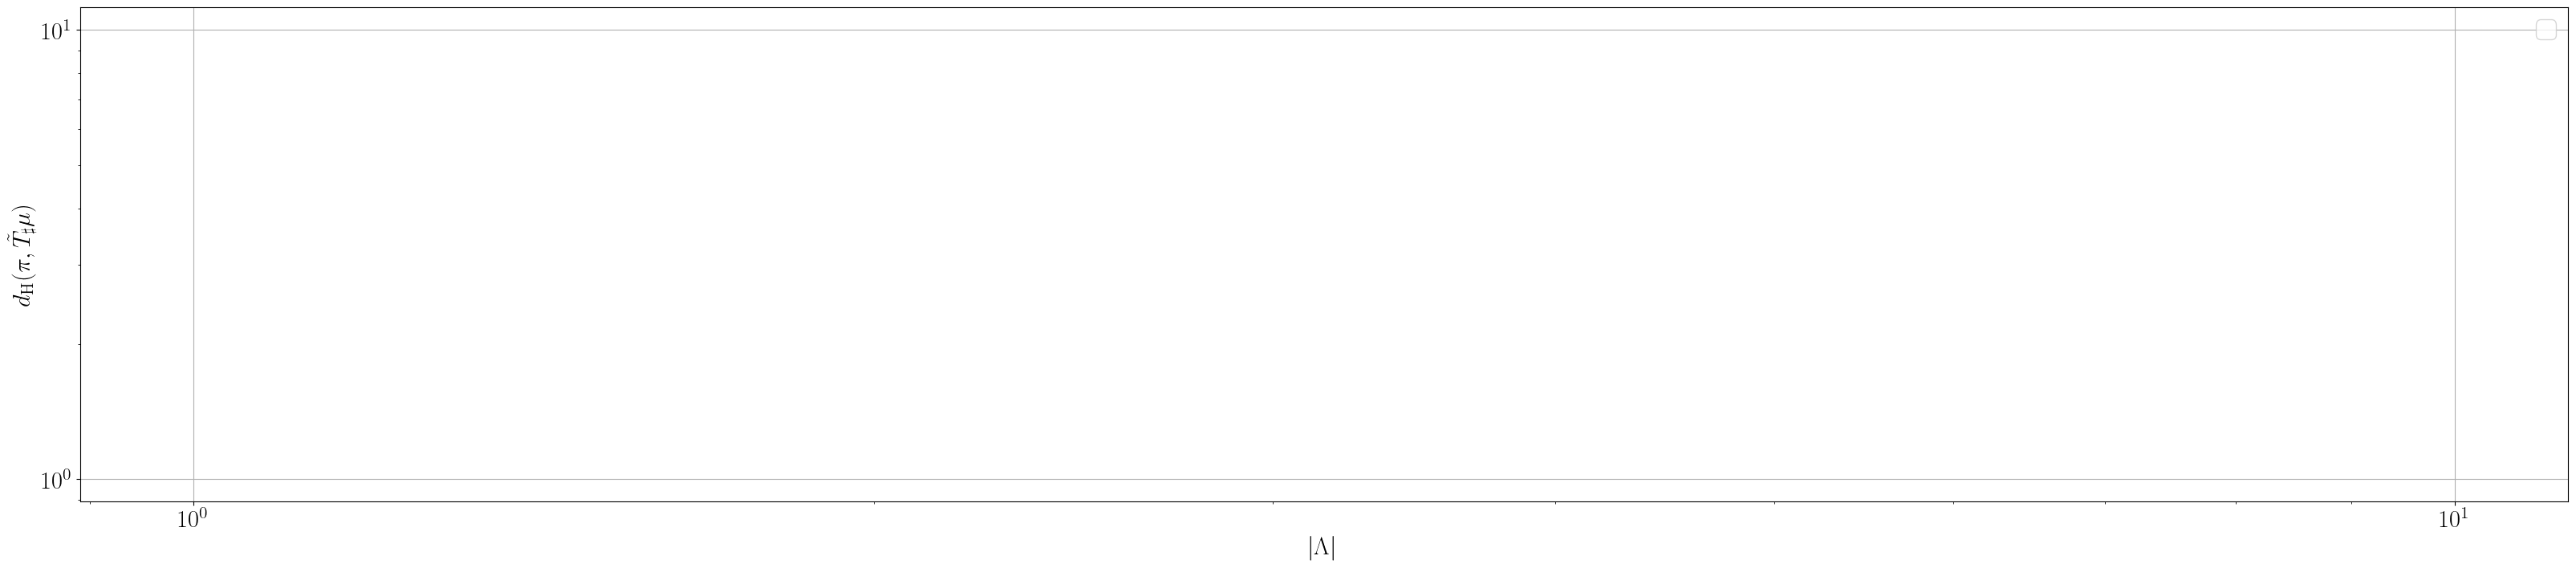

In [1]:
import sys, time, cProfile, pstats, itertools
import numpy as np

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib
%matplotlib notebook
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22, 'figure.figsize' : (40, 8)})

import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False})

%load_ext autoreload
%autoreload 2

from Database import *
from Densities import *
from MultiIndex import *
from Surrogates import *
from Transport import *
from Forward import *

import plotutil, randutil, basis

query_gauss = """
select {}
  from surrogateevaldbo as evl
  join surrogatedbo as sur
    on evl.surrog_id = sur.id
  join gaussianposteriordbo as tar 
    on sur.target_id = tar.id
   and sur.target = 'posterior'
   and sur.pmode = '{}'
  join multiindexsetanisotropicdbo as mul
    on sur.multis_id = mul.id
  join convolutiondbo as fwd
    on tar.forwd_id = fwd.id
 where fwd.dim = {}
   and fwd.alpha = {}
   and tar.noise = {}
   and fwd.basis = '{}'
"""
#query_gauss.format('tar.id, mul.size, evl.l2dist', 'multiindexsetanisotropicdbo', 1)

def plot_convolution_hedist_convergence_single(alpha=1, noise=.02, ds=[3, 7, 15, 31, 63, 127], pmode='cheby', qoi='evl.hedist', basis='hats', fig=None, nx=1, ny=1, idx=1, title='', verbose=False) :
    ax = plotutil.get_ax(fig=fig, nx=nx, ny=ny, idx=idx, xlabel=r'$|\Lambda|$', ylabel=r'$d_{\rm H}(\pi, \tilde{T}_\sharp \mu)$', title=title, logaxis=['x', 'y'])
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for (i, d) in enumerate(ds) :
        cursor = DB.execute_sql(query_gauss.format('tar.id, mul.size, ' + qoi, pmode, d, alpha, noise, basis))
        col_names = [col[0] for col in cursor.description] 
        res = sorted([dict(zip(col_names, row)) for row in cursor.fetchall()], key=lambda x : x['id'])
        
        res2 = dict()
        for gk, g in itertools.groupby(res, lambda x : x['id']) :
            #print(gk)
            data = np.array([[r['size'], r[qoi.split('.')[1]]] for r in sorted(g, key=lambda x :  x['size']) if r[qoi.split('.')[1]] is not None])
            try :
                if len(data) > 0 :
                    plt.plot(data[:, 0], data[:, 1], c=cycle[i], ls='dashed', alpha=.2)
            except IndexError :
                print('error', d, data)

            for da in data :
                if da[0] not in res2.keys() : res2[da[0]] = [da[1]]
                else : res2[da[0]].append(da[1])

        if res2 :
            keys = [k for k in sorted(res2.keys())]
            if verbose : print(noise, alpha, [len(res2[k]) for k in keys])
            mean = [np.mean(res2[k]) for k in keys]
            minm = [np.min(res2[k]) for k in keys]
            maxm = [np.max(res2[k]) for k in keys]
            #if d == 160 : print(keys[-1], mean[-1])
            ax.plot(keys, np.array(mean), c=cycle[i], lw=4, label=str(d))
            ax.fill_between(keys, minm, maxm, color=cycle[i], alpha=.05)
    ax.legend()

plot_convolution_hedist_convergence_single(alpha=1, noise=.1, basis='hats')

In [6]:
tex = 1
if tex : matplotlib.use('pgf')
else :   matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt

alpha=2
noise=.1
ds=[3, 7, 15, 31, 63, 127]
pmode='cheby'
qoi='evl.hedist'
matplotlib.rcParams.update({'font.size': 11})
ax = plotutil.get_ax(fig=plt.figure(figsize=(6.5, 2.5)), xlabel=r'$|\Lambda|$', ylabel=r'$d_{\rm H}(\pi, T_\sharp \mu)$', 
                     logaxis=['x', 'y'])
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['o', 'x', 's', '*', '^', 'D', 'x', 'v']
markersizes = [6,8,6,7,7,6]
for (i, d) in enumerate(ds) :
    cursor = DB.execute_sql(query_gauss.format('tar.id, mul.size, ' + qoi, pmode, d, alpha, noise, 'hats'))
    col_names = [col[0] for col in cursor.description] 
    res = sorted([dict(zip(col_names, row)) for row in cursor.fetchall()], key=lambda x : x['id'])

    res2 = dict()
    for gk, g in itertools.groupby(res, lambda x : x['id']) :
        data = np.array([[r['size'], r[qoi.split('.')[1]]] for r in sorted(g, key=lambda x :  x['size']) if r[qoi.split('.')[1]] is not None and r[qoi.split('.')[1]] > 1e-4])
        for da in data :
            if da[0] not in res2.keys() : res2[da[0]] = [da[1]]
            else : res2[da[0]].append(da[1])

    keys = [k for k in sorted(res2.keys())]
    mean = [np.mean(res2[k]) for k in keys]
    ax.plot(keys, np.array(mean), c=cycle[i], 
            marker=markers[i], markerfacecolor='none', markersize=markersizes[i], 
            linestyle='dotted', label=r'$d={}$'.format(d))
ax.legend(prop={'size': 9})

plt.tight_layout()
if tex : plt.savefig('/home/uq/notes/02 transport maps paper/convolution_error.pgf', format='pgf')
else :   plt.show()

In [45]:
[np.ceil(np.log2(i+1)) for i in range(1,15)]

[1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]

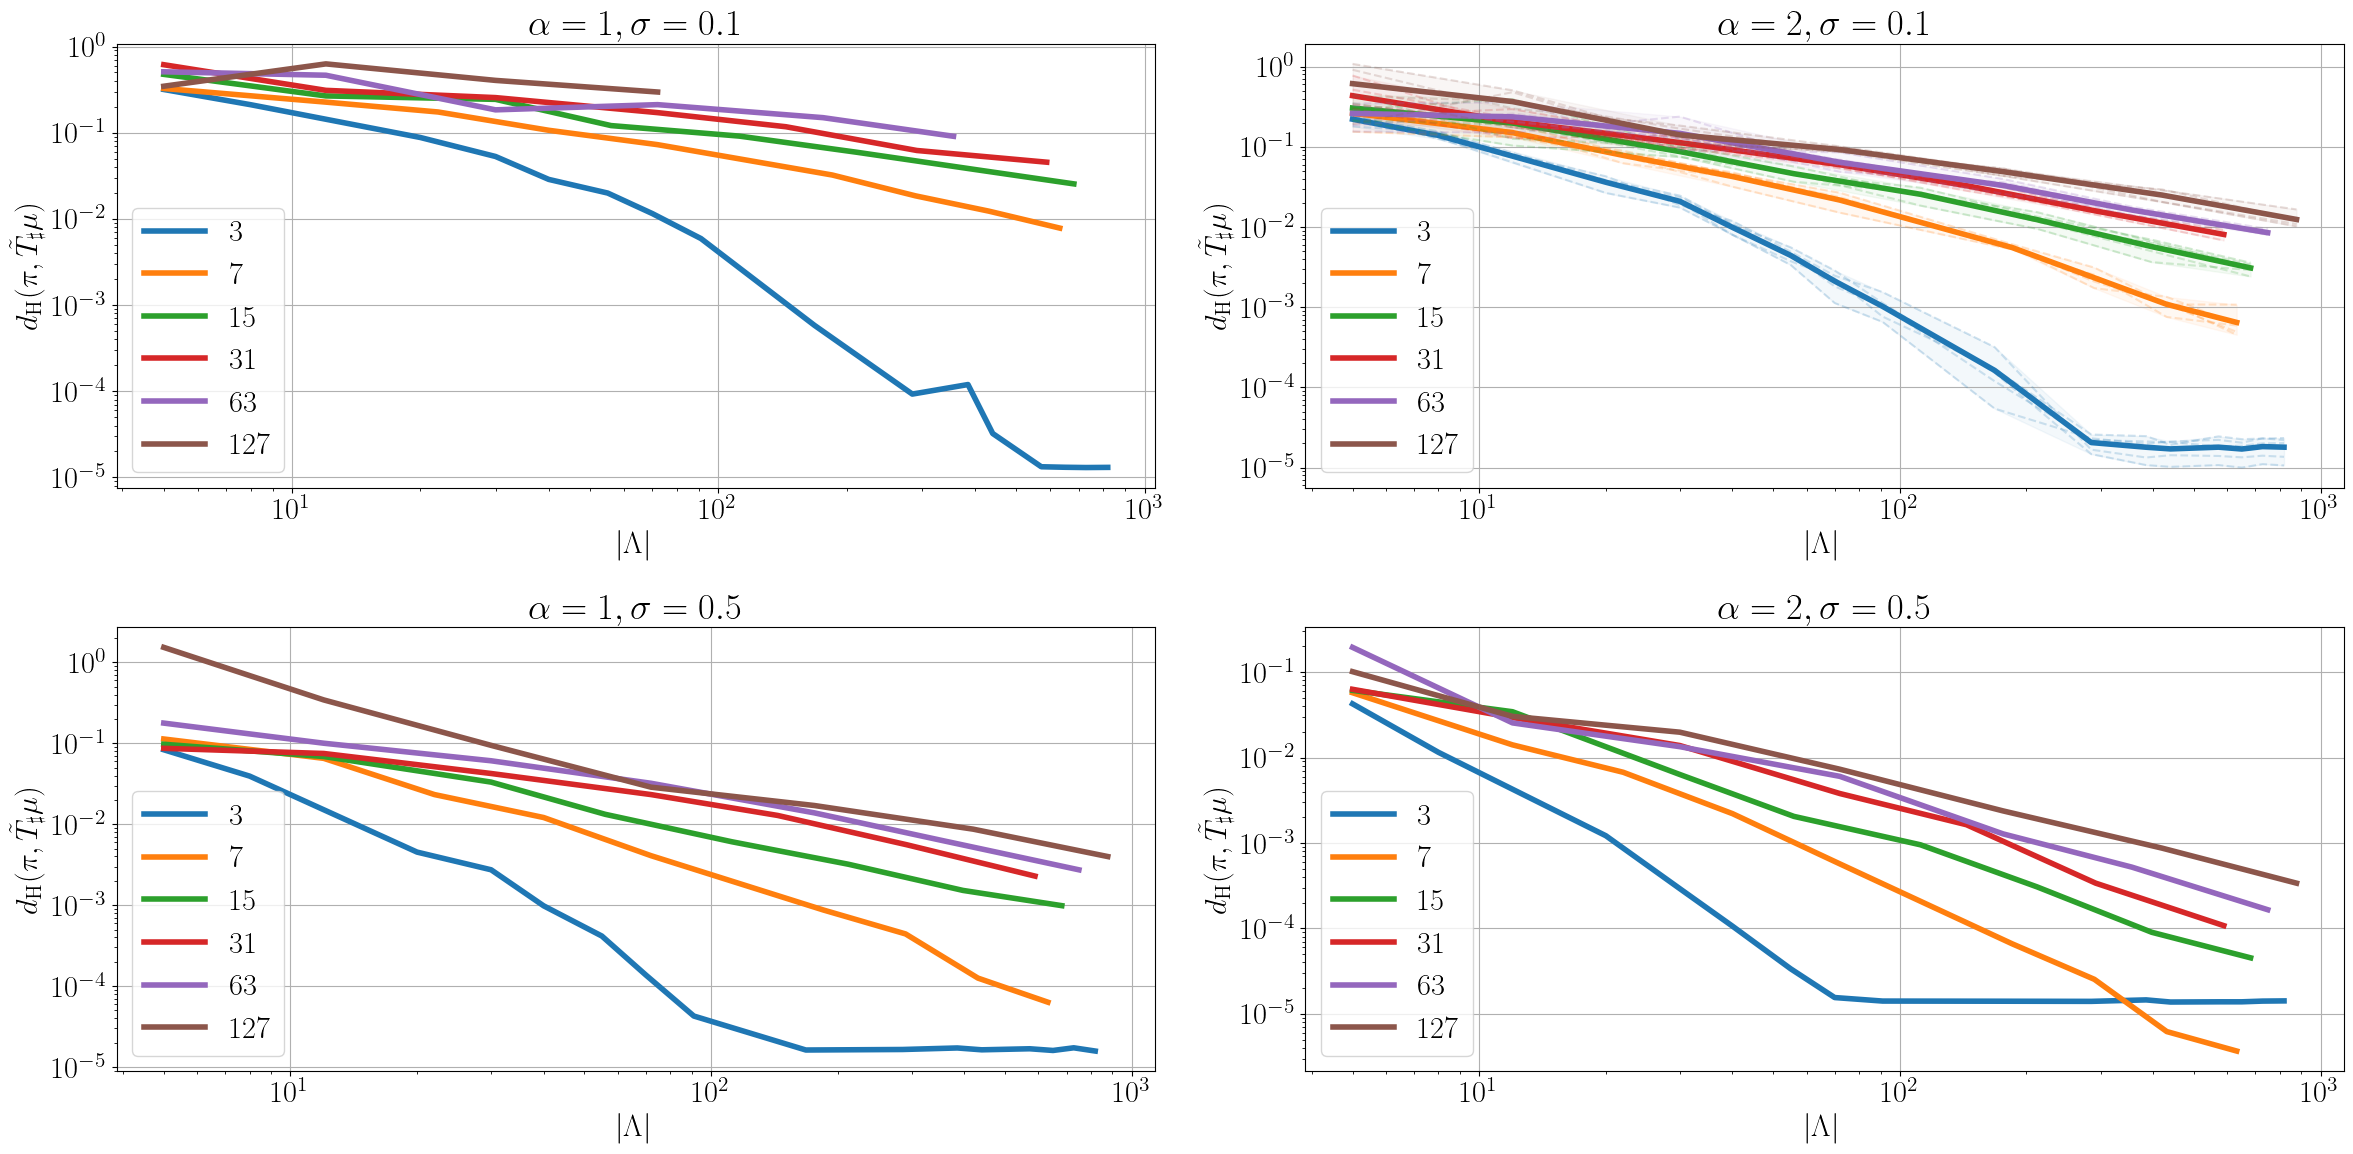

In [2]:
def plot_convergence(*, alphas=[1,2], noises=[.1,.5], verbose=False) :

    fig = plt.figure(figsize=(12*len(alphas), 6.*len(noises)))
    for i, alpha in enumerate(alphas) :
        for j, noise in enumerate(noises) :
            plot_convolution_hedist_convergence_single(alpha=alpha, noise=noise, fig=fig, nx=len(alphas), ny=len(noises), idx=i+1+j*len(alphas), title=r'$\alpha = {}, \sigma = {}$'.format(alpha, noise))
    plt.tight_layout()

    if False :
        filename = 'num_ex_l2_error.'
        plt.savefig(filename+'pdf', format='pdf')
        #tikzplotlib.save(filename+'tex')
    plt.show()
    
plot_convergence()

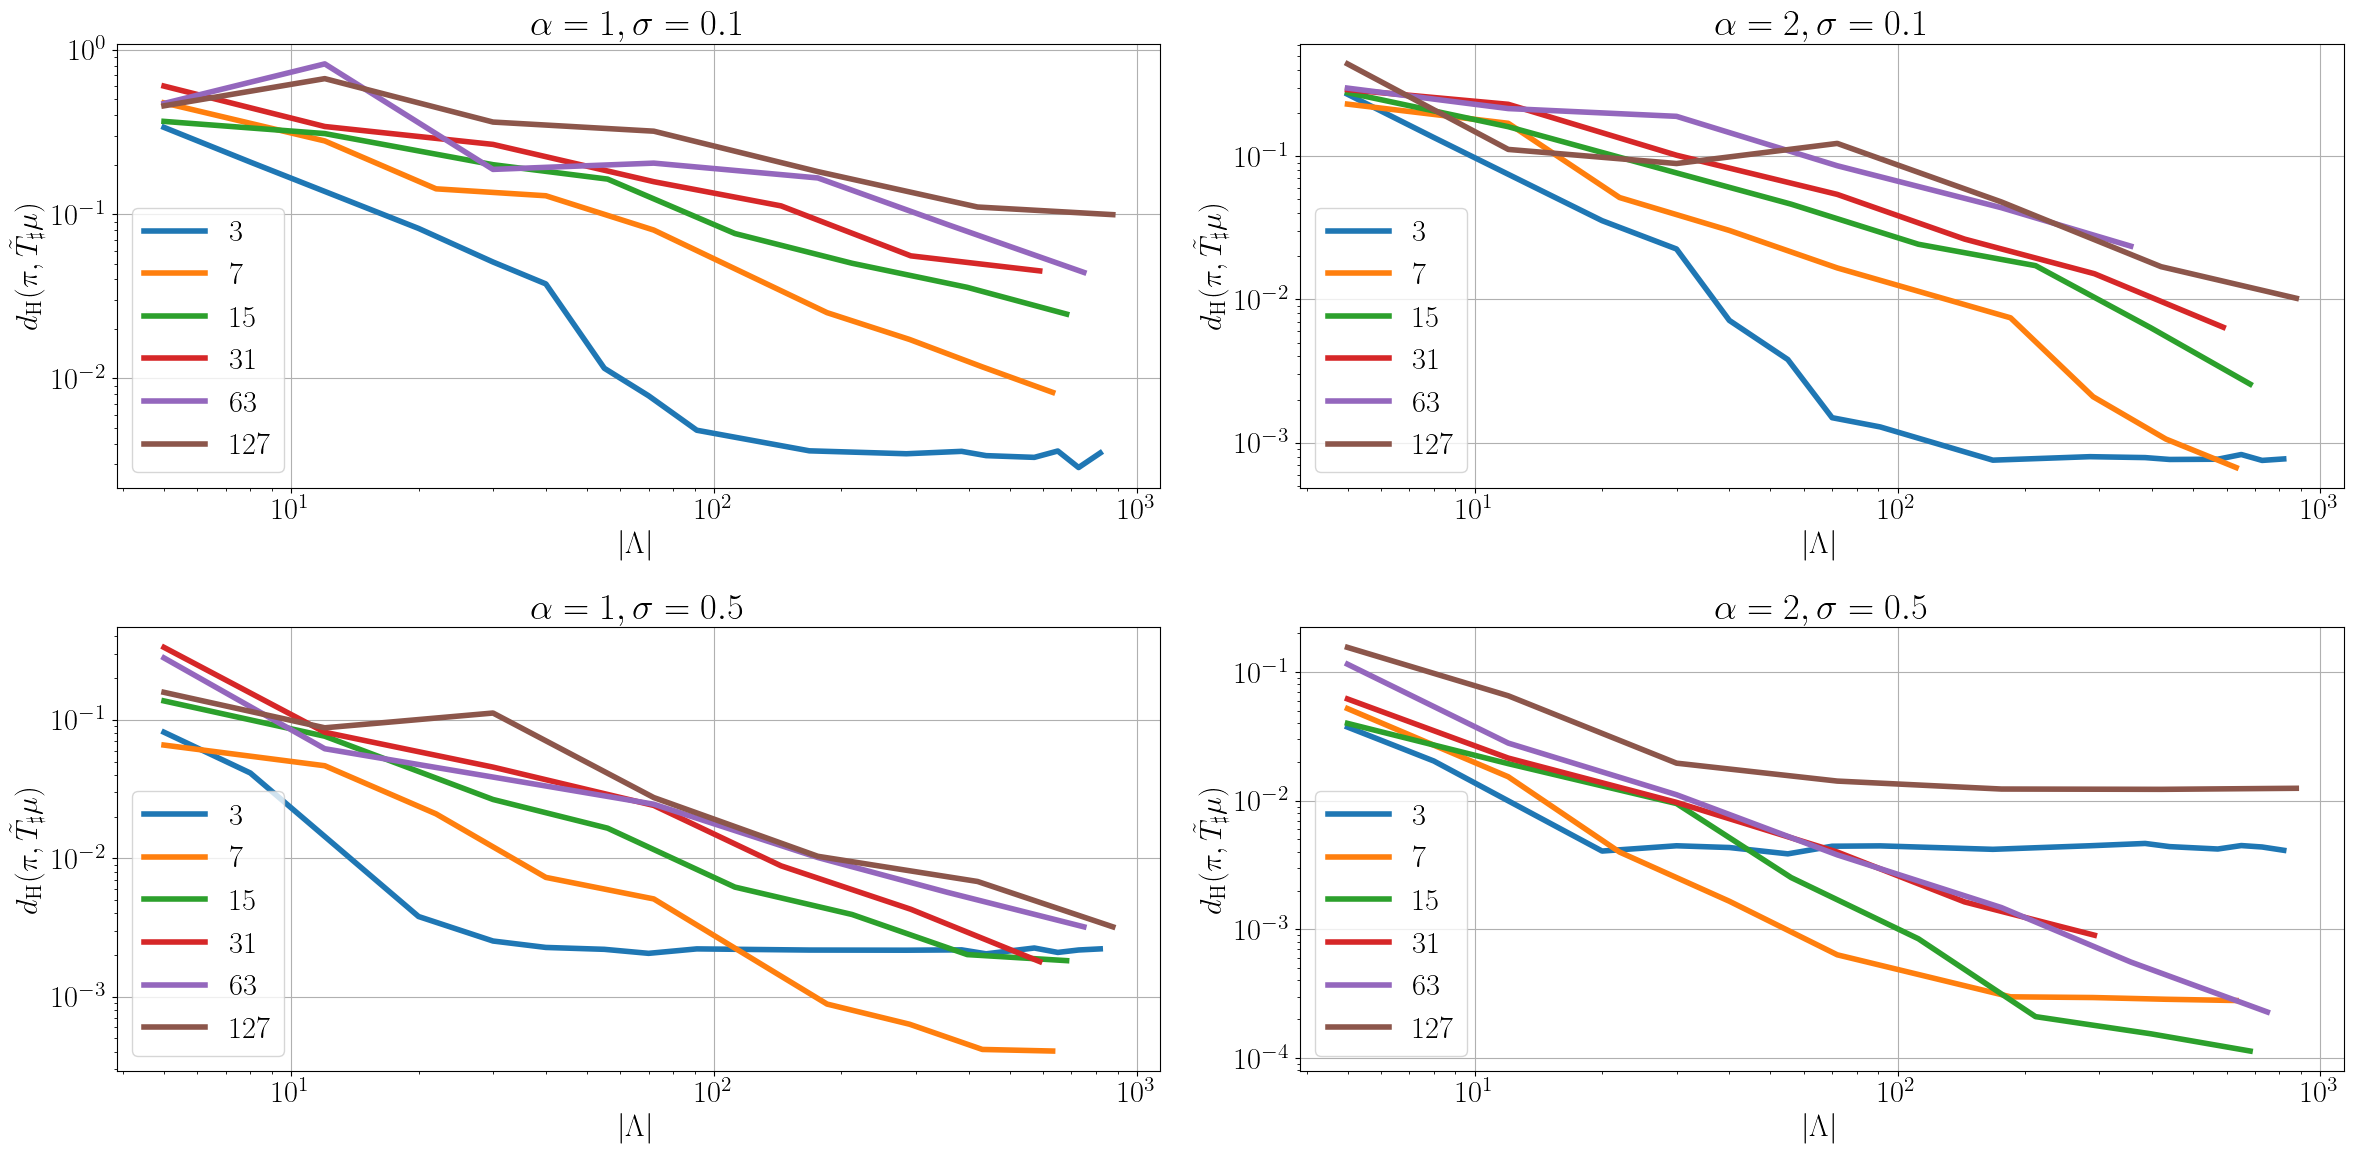

In [2]:
plot_convergence()

In [7]:
tex = 1

# Basis Functions

In [12]:
def psi_function(l, i, y, c=None, alpha=2):
    if c is None : c = 2**(-alpha*l) #1/(l+1)**(alpha) #2**(-alpha * (2**l + i - 1) )
    if y+1 >= i / 2**(l-1) and y+1 < (i + .5) / 2**(l-1):
        return c * (y+1 - i / 2**(l-1)) * 2**l
    elif y+1 >= (i + .5) / 2**(l-1) and y+1 <= (i + 1) / 2**(l-1):
        return c * ((i+1) / 2**(l-1) - (y+1)) * 2**l
    else:
        return 0

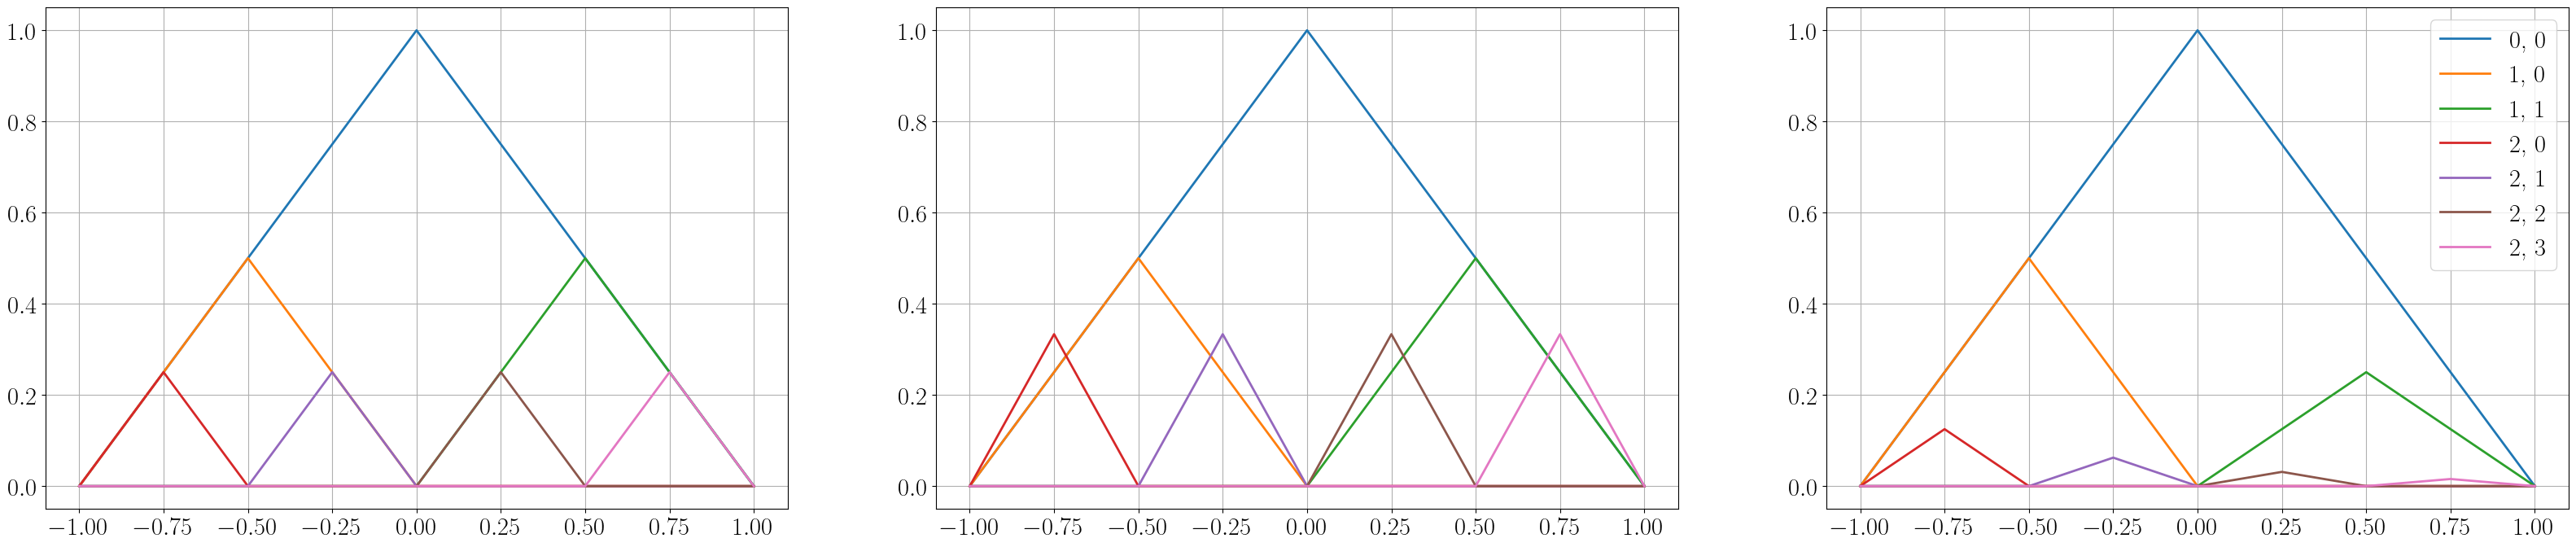

In [22]:
fig = plt.figure(figsize=(40, 8))
alpha = 1

y_vals = np.linspace(-1, 1, 201)

ax = plotutil.get_ax(fig=fig, nx=3, idx=1)
for l in range(3) :
    for i in range(2**l) :
        c = 2**(-alpha*l)
        plt.plot(y_vals, [psi_function(l, i, y, c=c, alpha=alpha) for y in y_vals], lw=2, label=str(l)+', '+str(i))
plt.grid(True)

ax = plotutil.get_ax(fig=fig, nx=3, idx=2)
for l in range(3) :
    for i in range(2**l) :
        c = (l+1)**(-alpha)
        plt.plot(y_vals, [psi_function(l, i, y, c=c, alpha=alpha) for y in y_vals], lw=2, label=str(l)+', '+str(i))
plt.grid(True)

ax = plotutil.get_ax(fig=fig, nx=3, idx=3)
for l in range(3) :
    for i in range(2**l) :
        c = 2**(-alpha * (2**l + i - 1) )
        plt.plot(y_vals, [psi_function(l, i, y, c=c, alpha=alpha) for y in y_vals], lw=2, label=str(l)+', '+str(i))
plt.grid(True)
plt.legend()
plt.show()

In [10]:
b = basis.hats
if tex : matplotlib.use('pgf')
else   : matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"font.family": "serif", 'font.size'  : 15, "text.usetex": True, "pgf.rcfonts": False})

alpha = 2
x_eval = np.linspace(-1,1,201)
ax1 = plotutil.get_ax(fig=plt.figure(figsize=(4,4)), xlabel=r'$y$')
ax1.plot(x_eval, [b(xi, [1], alpha=alpha) for xi in x_eval], lw=2, label=r'$\psi_{{0, 0}}(y)$')
for l in range(1,4) :
    ax1.plot(x_eval, [b(xi, [0] * (2**l - 1) + [1] * 2**l, alpha=alpha) for xi in x_eval], lw=2, label=r'$(\psi_{{ {}, i}}(y))_{{i=0}}^{{ {} }}$'.format(l,2**l-1))
ax1.legend()
plt.tight_layout()
if tex : plt.savefig('/home/uq/notes/02 transport maps paper/fig/convolution_basis.pgf', format='pgf')
else   : plt.show()

# Signal Function

In [11]:
if tex : matplotlib.use('pgf')
else   : matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"font.family": "serif", 'font.size'  : 15, "text.usetex": True, "pgf.rcfonts": False})

d = 15
alpha = 1

if not tex : 
    param = randutil.points(d)

ax = plotutil.get_ax(fig=plt.figure(figsize=(4,4)), xlabel=r'$y$')#, title=r'$s_\ell(y)$ and $s(y)$')
for l in range(int(np.log2(d))+1) :
    ax.plot(x_eval, [b(xi, [0] * (2**l - 1) + list(param[2**l-1:2*2**l-1]), alpha=alpha) for xi in x_eval], lw=2, label=r'$s_{}(y)$'.format(l))
ax.plot(x_eval, [b(xi, param, alpha) for xi in x_eval], 'k', lw=4, label=r'$s(y)$')
ax.legend()
#ax.set_yticks([-.3, -.2, -.1, 0, .1])
plt.tight_layout()
if tex : plt.savefig('/home/uq/notes/02 transport maps paper/fig/convolution_signal.pgf', format='pgf')
else   : plt.show()

# Convoluted Signal

In [12]:
if tex : matplotlib.use('pgf')
else   : matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"font.family": "serif", 'font.size'  : 15, "text.usetex": True, "pgf.rcfonts": False})
matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=["usepackage{amsmath}"]

noise = .02
chi = np.linspace(-.9,.9,10)
if not tex :
    f = fw.Convolution(basis=basis.hats, dim=d, alpha=alpha, xmeas=chi, save=True)
    m = f.eval(param) + noise*np.random.randn(len(chi),1)
    t = GaussianPosterior(forwd=f, truep=param, noise=noise, save=True)

F_x_meas = t.gauss.mean
F_x_eval = t.forwd.eval(param, xmeas=x_eval)

ax = plotutil.get_ax(fig=plt.figure(figsize=(4,4)), xlabel=r'$y$')#, title=r'$c(y)$ and $m$')
ax.plot(x_eval, F_x_eval, label=r'$c(y)$')
ax.scatter(chi, F_x_meas, label=r'$(m_j)_{j=1}^n$')
#ax.set_yticks([.02, -.02, -.06, -.1, -.14])

ax.legend()
plt.tight_layout()
if tex : plt.savefig('/home/uq/notes/02 transport maps paper/fig/convolution_measurement.pgf', format='pgf')
else   : plt.show()

In [90]:
print(chi+1, [(2*i+1)/10 for i in range(10)])

[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9] [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]


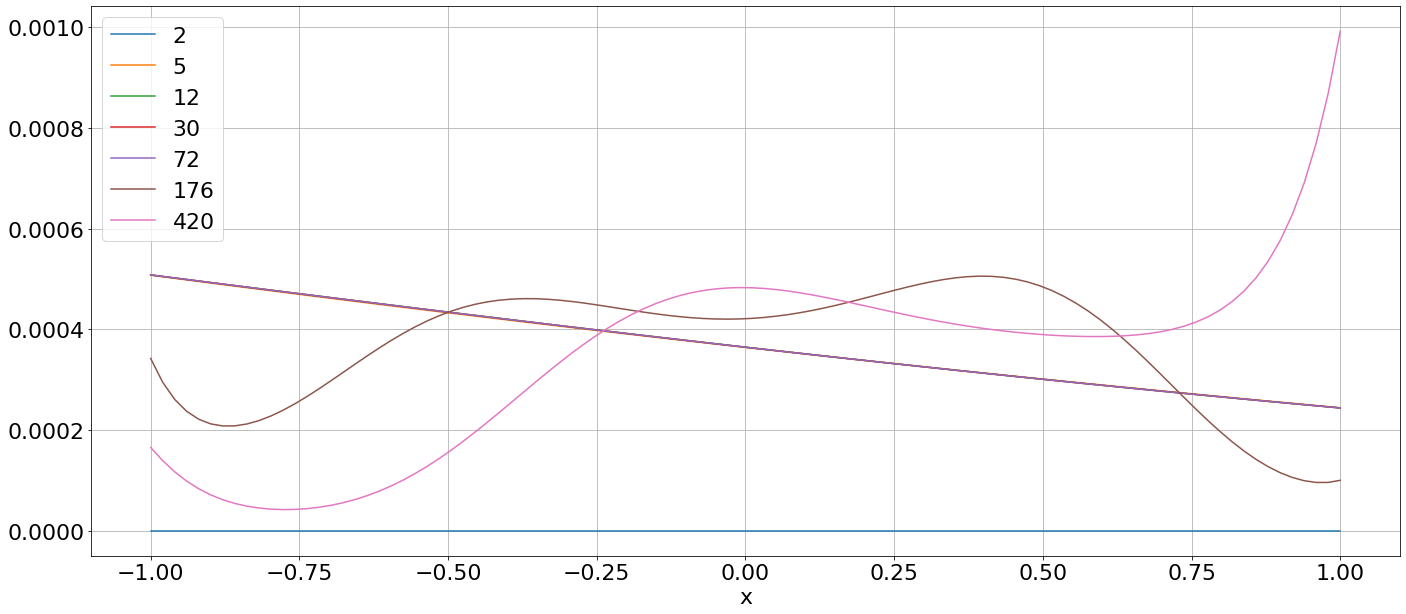

In [21]:
def peek_at_densitiy(*, method='wls', idd=505, alpha=1, noise=.5, basis=basis.hats_cdec, dist='l2dist', mins={}, xeval=np.linspace(-1,1,7), verbose=False) :
    fig = plt.figure(figsize=(20,9))
    ax = plotutil.get_ax(fig, 1, 1)#, title=r'$\sigma=$'+str(noise)+r', $\alpha=$'+str(alpha))
    
    t = GaussianPosterior.fromId(idd)
    
    n = 100
    x = np.linspace(-1,1,n)
    pts = np.tile(randutil.points(t.dim,1), (1,n))
    pts[0,:] = x
    
    for s in SurrogateDBO.select().where(SurrogateDBO.target=='posterior' and SurrogateDBO.target_id==t.dbo.id) :
        l = Legendre.fromDbo(s)
        plt.plot(x, l.eval(pts), label=str(l.multis.size()))

    ax.legend()
    plt.tight_layout()
    plt.show()

peek_at_densitiy(idd=71)

In [23]:
def plot_convolution(posteriorid) :

    t = GaussianPosterior.fromId(posteriorid)
    param = db.fr_string(t.dbo.truep)
    x_meas = db.fr_string(t.dbo.xeval)

    x_eval = np.linspace(-1,1,101)
    q = basis.hats_cdec
    alpha = 2
    verbose = False

    F_x_meas = db.fr_string(t.gauss.dbo.mean)

    F_x_eval = t.forwd.eval(param, xeval=x_eval)

    fig = plt.figure(figsize=(30,8))
    ax = plotutil.get_ax(fig, 2, 1, title='q(x)')
    ax.plot(x_eval, [q(xi, param, alpha) for xi in x_eval], 'k', lw=4, label='q(x)')
    for i in range(len(param)) :
        ax.plot(x_eval, [q(xi, [0]*i + [param[i]], alpha) for xi in x_eval], lw=3, label=r'$q_{}(x)$'.format(i), alpha=.4)
    ax = plotutil.get_ax(fig, 2, 2, title=r'F(q)(x) + $\eta$')
    ax.plot(x_eval, F_x_eval, label='F(q)(x)')
    ax.scatter(x_meas, F_x_meas, label=r'$(x_j, m_j)_{j=1}^M$')
    plt.tight_layout()

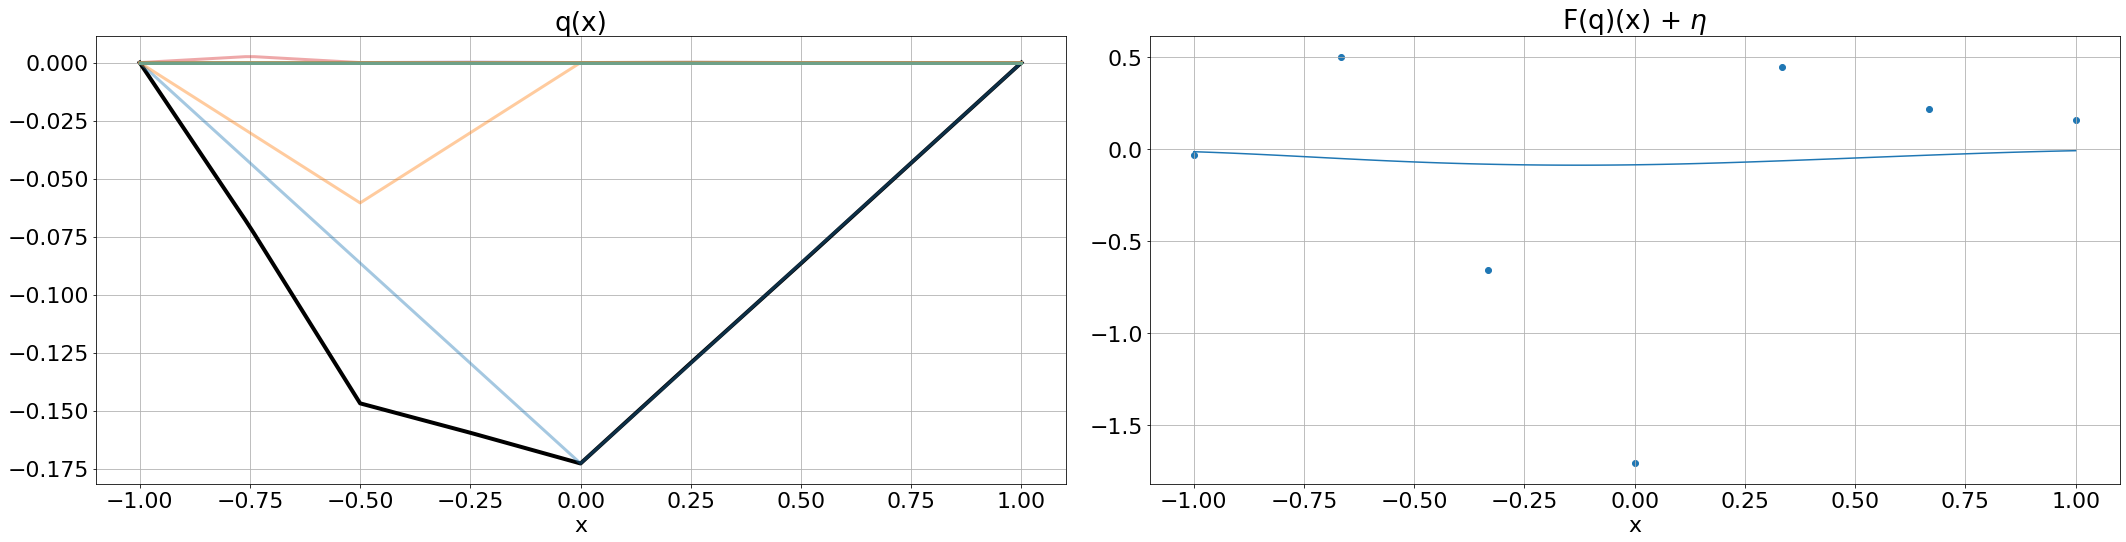

In [24]:
plot_convolution(71)

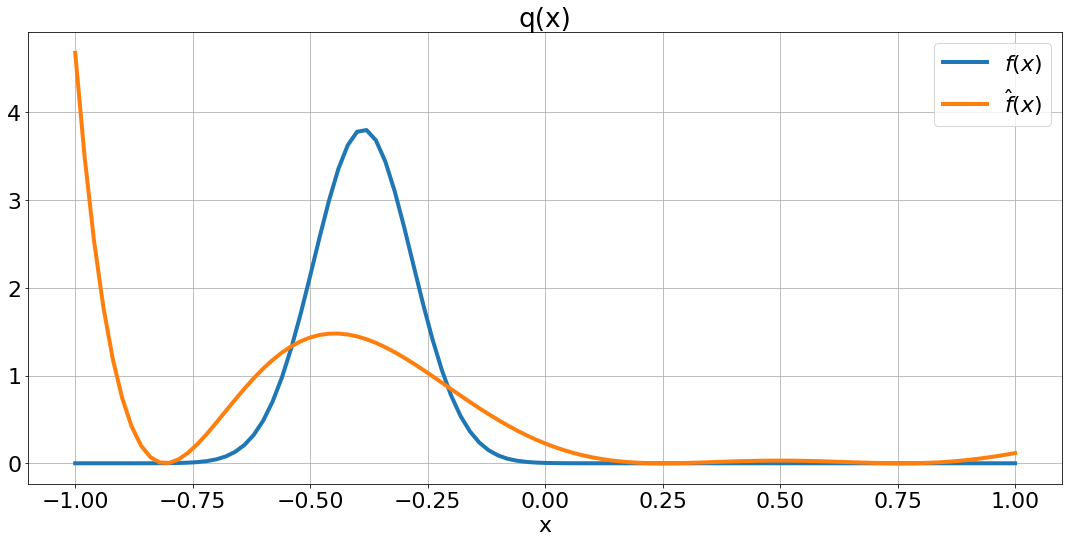

In [3]:
teval = [t.eval(np.array([xi]))/(2/len(x_eval)) for xi in x_eval]
seval = [s.eval(np.array([xi]))/(2/len(x_eval)) for xi in x_eval]
dx = 2/(len(x_eval)-1)
teval_norm = .5*dx*(teval[0] + teval[-1]) + np.sum(teval[1:-1])*dx
seval_norm = .5*dx*(seval[0] + seval[-1]) + np.sum(seval[1:-1])*dx
fig = plt.figure(figsize=(30,8))
ax = plotutil.get_ax(fig, 2, 1, title='q(x)')
ax.plot(x_eval, teval/teval_norm, lw=4, label=r'$f(x)$')
ax.plot(x_eval, seval/seval_norm, lw=4, label=r'$\hat{f}(x)$')
ax.legend()
plt.tight_layout()

select tar.id, mul.size, evl.l2dist
  from surrogateevaldbo as evl
  join surrogatedbo as sur
    on evl.surrog_id = sur.id
  join gaussianposteriordbo as tar 
    on sur.target_id = tar.id
   and sur.target = 'posterior'
  join multiindexsetanisotropicdbo as mul
    on sur.multis_id = mul.id
  join forwarddbo as fwd
    on tar.forwd_id = fwd.id
 where fwd.dim = 1
   and fwd.noise = .1
   and fwd.alpha = 1

In [113]:
def expectation(multiset, coeffs, p_grid, d) :
    transport = TransportMap(d, coeffs, multiset)
    p_grid_mapped = [transport.inverse_evaluate(p_grid[i]) for i in range(p_grid.shape[0])]
    print('\t', np.min(p_grid_mapped), np.max(p_grid_mapped))
    exp = np.mean(p_grid_mapped, axis=0)
    print('\t', exp)
    return exp

In [136]:
mesh = np.linspace(-1, 1, 20, endpoint=True)
X_grid, Y_grid = np.meshgrid(mesh, mesh)
X_sampled = np.vstack((np.ndarray.flatten(X_grid), np.ndarray.flatten(Y_grid)))

In [119]:
expected_p_4 = 0
p_norm = 0
for i in range(p_grid.shape[0]) :
    post = problem.P(x_meas, y_meas, q, p_grid[i], sigma, alpha)
    expected_p_4 += post * p_grid[i]
    p_norm += post
expected_p_4 /= p_norm

[-0.98385925  0.62444806  0.72935764 -0.86043561]


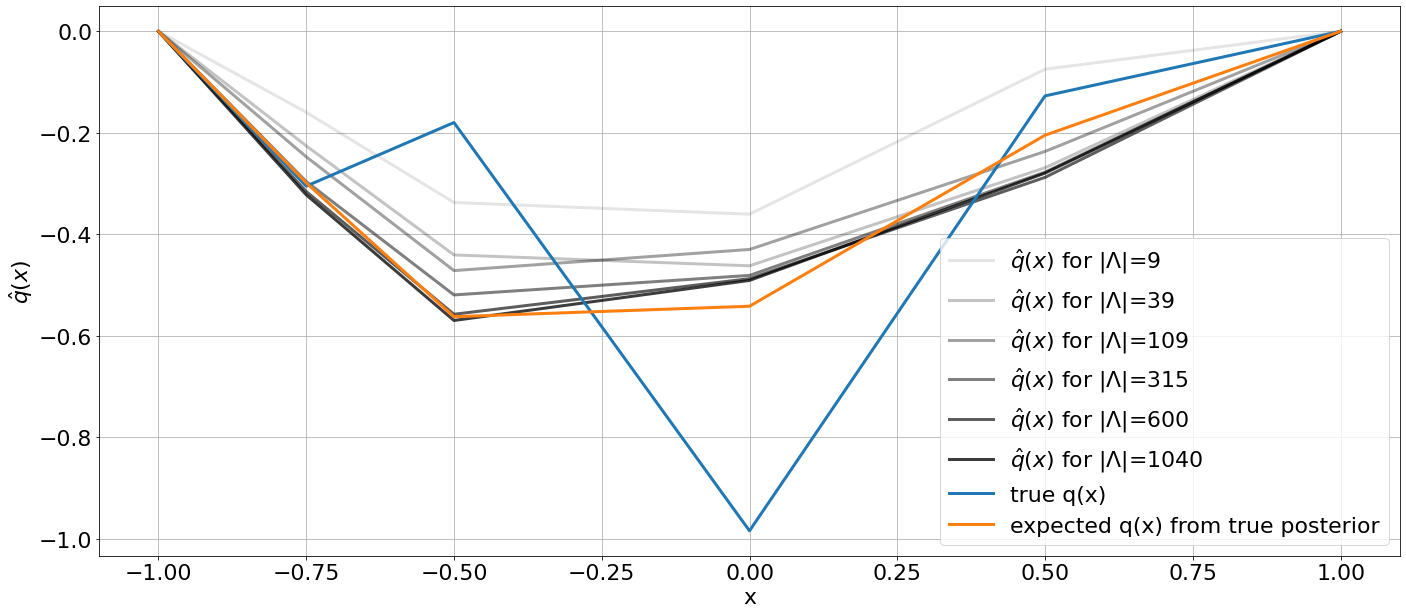

In [123]:
print(p)
q = basis.hats
fig = plt.figure(figsize=(20,9))
ax = plotutil.get_ax(fig, 1, 1, title='', ylabel=r'$\hat{q}(x)$')
for i in range(len(expts)) : 
    ax.plot(x_grid, [q(xi, expts[i], alpha) for xi in x_grid], 'k', alpha=.1+.8*i/len(expts), label=r'$\hat{q}(x)$' + ' for $|\Lambda|$={}'.format(int(lambdas[i])), lw=3)
ax.plot(x_grid, [q(xi, p, alpha) for xi in x_grid], label='true q(x)',  lw=3)
ax.plot(x_grid, [q(xi, expected_p_4, alpha) for xi in x_grid], label='expected q(x) from true posterior',  lw=3)
ax.legend()
plt.tight_layout()

if True :
    filename = '../../overview/figures/alpha={}/expectation_{}d.'.format(alpha, d)
    plt.savefig(filename+'pdf', format='pdf')